# simple MNIST_demo


In [1]:
import os
from os.path import join

import struct
from array import array

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms

import sklearn
from sklearn.linear_model import LogisticRegression

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Loading in MNIST data

In [73]:
import struct
import numpy as np

class MnistData(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        # Read labels correctly (each label is 1 byte)
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f"Magic number mismatch, expected 2049, got {magic}")

            labels = np.frombuffer(file.read(size), dtype=np.uint8)  # ✅ Read exactly `size` bytes, 1 byte per label
        
        # Read images correctly
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f"Magic number mismatch, expected 2051, got {magic}")

            image_data = np.frombuffer(file.read(size * rows * cols), dtype=np.uint8)  # ✅ Read correctly
            images = image_data.reshape(size, rows, cols)  # ✅ Reshape into (60000, 28, 28) or (10000, 28, 28)
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

In [74]:
input_path = os.path.abspath(os.path.join(os.getcwd(), "../data")).replace("\\","/") +"/"
training_images_filepath = input_path + 'train-images-idx3-ubyte'
training_labels_filepath = input_path + 'train-labels-idx1-ubyte'
test_images_filepath = input_path + 't10k-images-idx3-ubyte'
test_labels_filepath = input_path + 't10k-labels-idx1-ubyte'

mnist_dataloader = MnistData(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# basic exploratory analysis

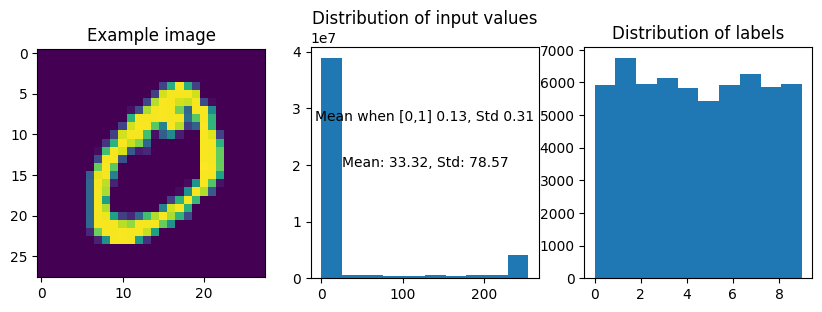

In [100]:
# basic exploratory analysis
fig = plt.figure(figsize=(10, 3))
# plot example image
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Example image")
ax1.imshow(x_train[1]);
# plot distribtuion of input values
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Distribution of input values")
ax2.text(0.5, 0.5, f"Mean: {x_train.flatten().mean():.2f}, Std: {x_train.flatten().std():.2f}",
         ha='center', va='center', transform=ax2.transAxes)
ax2.text(0.5, 0.7, f"Mean when [0,1] {x_train.flatten().mean()/255:.2f}, Std {x_train.flatten().std()/255:.2f}",
         ha='center', va='center', transform=ax2.transAxes)



ax2.hist(x_train.flatten());
# plot distribution of labels

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Distribution of labels")
ax3.hist(y_train);

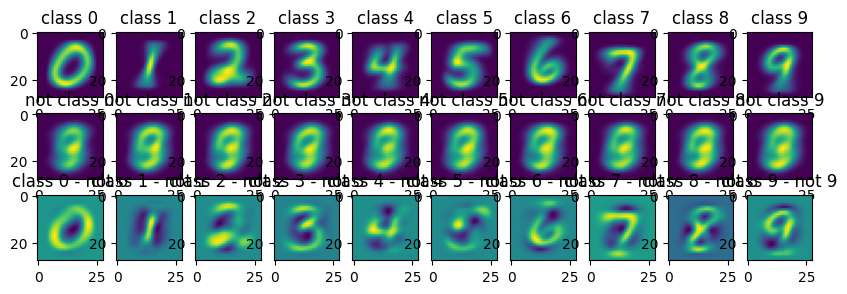

In [187]:
fig = plt.figure(figsize = (10,3))

for i in range(0,10):
    ax1 = fig.add_subplot(3,10,i+1)
    ax1.imshow(x_train[y_train == i].mean(axis=0).reshape(28,28))
    ax1.set_title(f"class {i}")
    ax2 = fig.add_subplot(3,10,i+11)
    ax2.imshow(x_train[y_train != i].mean(axis=0).reshape(28,28))
    ax2.set_title(f"not class {i}")
    ax3 = fig.add_subplot(3,10,i+21)
    ax3.imshow(x_train[y_train == i].mean(axis=0).reshape(28,28) - x_train[y_train != i].mean(axis=0).reshape(28,28))
    ax3.set_title(f"class {i} - not {i}")

## creating dataset and loaders 

In [248]:
## define datasets 
class ImageDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.transform = transforms.Compose([
            transforms.ToTensor(), #autoconverts scales to [0,1]
            #transforms.Normalize((0.5,), (0.5,)) #normalizes to [-1,1] - alternatively can use transforms.Normalize((0.1307,), (0.3081,)) - specific for MNIST
        ])

        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # Convert numpy arrays to torch tensors
        x = self.transform(self.x_data[idx])
        y = torch.LongTensor([self.y_data[idx]]).squeeze()
        return x, y


class FlatDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.transform = transforms.Compose([
            transforms.ToTensor(), #autoconverts scales to [0,1]
            #transforms.Normalize((0.5,), (0.5,)) #normalizes to [-1,1] - alternatively can use transforms.Normalize((0.1307,), (0.3081,)) - specific for MNIST
        ])
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.transform(self.x_data[idx]).view(1,-1).squeeze()
        y = torch.LongTensor([self.y_data[idx]]).squeeze()
        return x, y

# Create datset and dataloader
image_train_dataset = ImageDataset(x_train, y_train)
image_train_dataloader = DataLoader(image_train_dataset, batch_size=32, shuffle=True)
image_test_dataset = ImageDataset(x_test, y_test)
image_test_dataloader = DataLoader(image_test_dataset, batch_size=32, shuffle=False)

flat_train_dataset = FlatDataset(x_train, y_train)
flat_train_dataloader = DataLoader(flat_train_dataset, batch_size=32, shuffle=True)
flat_test_dataset = FlatDataset(x_test, y_test)
flat_test_dataloader = DataLoader(flat_test_dataset, batch_size=32, shuffle=False)


Define the models - 
1. Logistic regression
2. FCNN
3. very basic CNN
4. CNN based on efficient net paper

# logistic regression baseline

In [202]:
# flatten and stack inputs to feed into logreg [60000,28,28] -> [60000,28*28]
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)
# (x_train[0].flatten() == x_train_flat[0]).all()

logregmodel = LogisticRegression(max_iter=1000)
logregmodel.fit(x_train_flat, y_train)

KeyboardInterrupt: 

In [170]:
x_test_flat = x_test.reshape(x_test.shape[0],-1)
(logregmodel.predict(x_test_flat) == y_test).mean()

0.9202

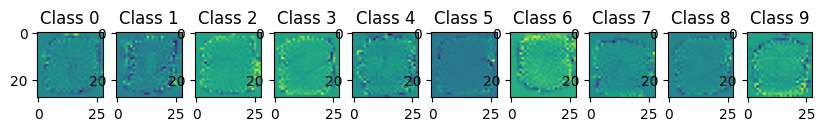

In [188]:
fig = plt.figure(figsize=(10,3))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(logregmodel.coef_[i].reshape(28,28))
    ax.set_title(f"Class {i}")

# Deep learning models

# Multilayer Perceptron

In [207]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.fc1(x) 
        return x


In [246]:
next(iter(flat_test_dataloader))[0].shape

torch.Size([32, 784])

In [ ]:
mlp_model = MLP().
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(10):
    # training loop
    train_loss = []
    for batch_x, batch_y in flat_train_dataloader:
        optimizer.zero_grad()
        output = mlp_model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_losses.append(train_loss)

    # validation loop
    with torch.no_grad():
        val_loss = []
        for batch_x, batch_y in flat_test_dataloader:
            output = mlp_model(batch_x)
            loss = loss_fn(output, batch_y)
            val_loss.append(loss.item())
        val_losses.append(val_loss)

        print(f"Epoch {epoch} loss: {np.mean(val_loss)}")

Epoch 0 loss: 0.30503397045758207
Epoch 1 loss: 0.27931502043677214
Epoch 2 loss: 0.27576876982760884
Epoch 3 loss: 0.26614194387159407
Epoch 4 loss: 0.26916356003298736
Epoch 5 loss: 0.2619524769151744
Epoch 6 loss: 0.2656761538772918
Epoch 7 loss: 0.2774224176574439
Epoch 8 loss: 0.26834705051855917
Epoch 9 loss: 0.2629600359311405


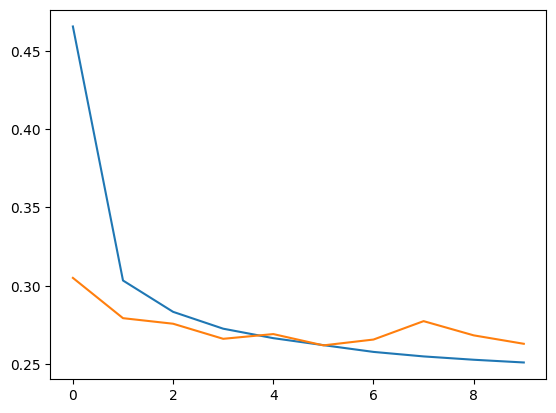

In [271]:
plt.plot(np.array(train_losses).mean(axis = 1))
plt.plot(np.array(val_losses).mean(axis = 1))


In [257]:
test = next(iter(flat_test_dataloader))[0]
mlp_model(test).argmax(dim=1)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])

In [ ]:
predictions = []
with torch.no_grad():
    for batch_x, batch_y in flat_test_dataloader:
        output = mlp_model(batch_x)
        predictions.append(output.argmax(dim=1))
predictions = torch.cat(predictions)
(predictions == y_test).mean()




# Convolutional Nerual Networks

## Basic CNN 

In [ ]:
#define a basic CNN
class BasicCNN(nn.Module):
    def __init__(self,kernel_size=3,stride=1,padding=1):
        super(BasicCNN, self).__init__()
        # inputs are [1, 28, 28]
        # defaults are kernel_size=3, stride=1, padding=1
        # output is [32, 28+2*padding-kernel_size+1, 28+2*padding-kernel_size+1]
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=stride, padding=padding) # [1, 28, 28] -> [32, 28, 28]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # [32, 28, 28] -> [32, 14, 14] 
        self.relu = nn.ReLU() # [32, 14, 14] -> [32, 14, 14]
        self.flatten = nn.Flatten() # [32, 14, 14] -> [32*14*14] ([6272])
        self.fc1 = nn.Linear(32 * 7 * 7, 10) # [6272] -> [10] #output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

## EfficientNet